# Лабораторная работа №2

## Условие

Вариант №2

Распределения:

$$\mathbf{X} \sim R(2, 6)$$
$$\mathbf{Y} \sim R(2, 6)$$

Объёмы выборок:

$$ n_1 = 50$$
$$ n_2 = 50 $$

## Импорты

In [295]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from time import time
from IPython.display import display, Math, Markdown  # для вывода формул в консоль

## Определения

In [2]:
a1, b1, n1 = 2, 6, 50
a2, b2, n2 = 2, 6, 50

In [43]:
def mprint(*strings):
    for s in strings:
        display(Markdown(s))


np.random.seed(int(time()))
plt.rc("text", usetex=True)
plt.rc(
    "text.latex",
    preamble=r"""
\usepackage[english, russian]{babel}
\usepackage[utf8]{inputenc}
""",
)
plt.style.use("seaborn-v0_8")

In [39]:
alpha = 0.05


def verdict(alpha, p_value):
    if alpha > p_value:
        return "$H_0$ отклоняется"
    else:
        return "$H_0$ принимается"

## 1. Исходные данные

In [ ]:
X = np.random.uniform(a1, b1, n1)

mprint(f"$\\mathbf{{X}}$: {X[:10].round(2)}")

<IPython.core.display.Math object>

### Характеристики наблюдаемой величины $\mathbf X$

| Распределение | Параметры          | Математическое ожидание          | Дисперсия                                               |
| ------------- | ------------------ | -------------------------------- | ------------------------------------------------------- |
| $R(2, 6)$     | $a_1 = 2, b_1 = 6$ | $m_1 = \dfrac{a_1 + b_1}{2} = 4$ | $\sigma_1^2 = \dfrac{(b_1 - a_1)^2}{12} = \dfrac{4}{3}$ |

### Выборочные характеристики

Мы имеем выборку, нам нужно рассчитать **несмещенную** оценку с.к.о. и дисперсии, поэтому применяем формулы:

$$ s = \sqrt{\dfrac{1}{n - 1} \sum\limits_{i = 1}^{n} (x_i - \overline{x})^2} $$
$$ s^2 = \dfrac{1}{n - 1} \sum\limits_{i = 1}^{n} (x_i - \overline{x})^2 $$

Множитель $\dfrac{1}{n - a}$  в `numpy` достигается передачей параметра `ddof=a`, в данном случае `ddof=1`. 

In [8]:
mean1 = X.mean()
s1 = X.std(ddof=1)
S1 = X.var(ddof=1)

mprint(f"$\\overline{{x}} =$ {mean1:.2f}, $s^2 =$ {S1:.2f}, $s$ = {s1:.2f}")

<IPython.core.display.Math object>

| Среднее, $\overline{x_i}$ | Оценка дисперсии, $s_i^2$ | Оценка с.к.о., $s_i$ | 
| ------------------------- | ------------------------- | -------------------- | 
| 4.31                      | 1.04                      | 1.02                 | 


## 2. Визуальное представление выборки

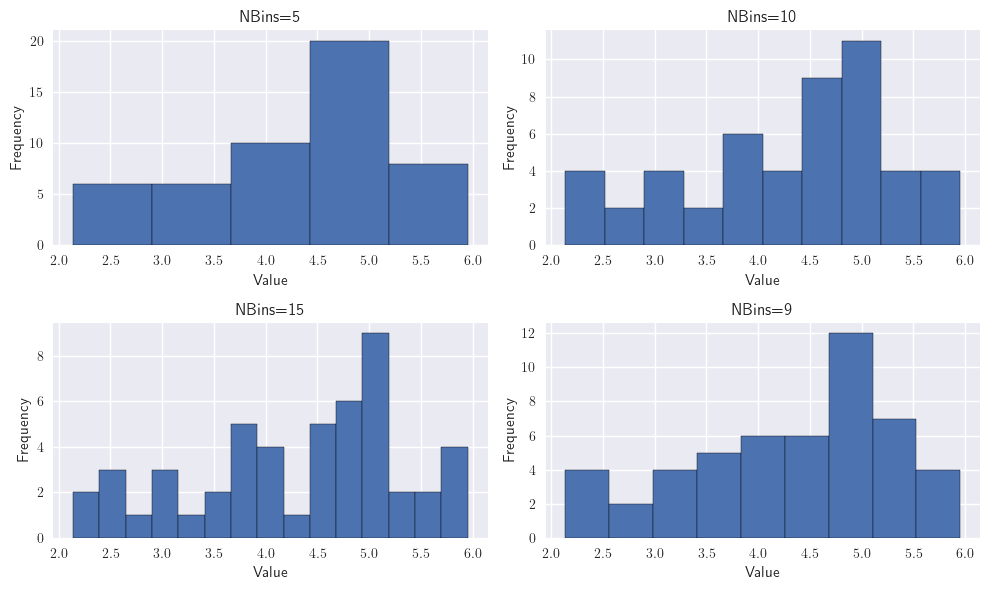

In [188]:
bins_list = [5, 10, 15, 9]

fig, axes = plt.subplots(2, 2, figsize=(10, 6))

for ax, NBins in zip(axes.flatten(), bins_list):
    ax.hist(X, bins=NBins, edgecolor="black")
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")
    ax.set_title(f"{NBins=}")
plt.tight_layout()  # оптимизирует отступы
plt.show()

## 3. Критерий $\chi^2$

### Теоретическая справка

У нас есть выборка объёма $n$: $x_1, x_2, \dots, x_n$ случайной величины $\mathbf X \sim F_X(x)$.

Мы хотим понять вид распределения случайной величины $\mathbf X$:
$$ H_0:\ F_X(x) = G(x) $$
$$ H_1:\ F_X(x) \neq G(x)  $$

Разбиваем выборку в группированный статистический ряд. Рекомендуется выбирать $\Delta_i$ так, чтобы $n \cdot p_i \gtrsim 5$ 

| $\Delta_i$ | $\Delta_1$ | $\cdots$ | $\Delta_k$ |
| ---------- | ---------- | -------- | ---------- |
| $n_i$      | $n_1$      | $\cdots$ | $n_k$      |

$n_i$ - частота попадания случайной величины $\mathbf X$ в интервал $\Delta_i$.

$p_i$ - вероятность попадания случайной величины $\mathbf X$ в интервал $\Delta_i$ в условиях $H_0$, то есть, если $\Delta_i = (a_{i-1}, a_{i}]$, то 

$$p_i = \int\limits_{a_{i-1}}^{a_{i}}g(x)dx = G(a_{i}) - G(a_{i-1})$$

Статистика критерия: 
$$Z = \sum\limits_{i=1}^k \dfrac{(n_i - n \cdot p_i)^2}{n \cdot p_i}$$
$$Z \mid_{H_0} \sim \chi^2(k-r-1),$$
где $r$ - количество оцениваемых параметров у $G$. 
Например:

1. если $H_0:\ \mathbf X \sim N(5, 2)$, то $r = 0$
2. если $H_0:\ \mathbf X \sim N(?, 2)$, то $r = 1$
3. если $H_0:\ \mathbf X \sim N(?, ?)$, то $r = 2$

При каком-то неизвестном параметре переформулируем задачу как $H_0:\ \mathbf X \sim N(\overline x, s)$, то есть используем МП-оценки для рассчёта параметров.



### Статистическая гипотеза $H_0:\ X \sim N(m, \sigma)$

In [103]:
def chi2_gof_normal(X, bins, m=None, std=None):
    n = len(X)
    r = 0
    if not m:
        m = X.mean()
        r += 1
    if not std:
        std = X.std(ddof=1)
        r += 1
    frequences, bin_edges = np.histogram(X, bins=bins)
    k = len(frequences)
    p_list = stats.norm.cdf(bin_edges[1:], loc=m, scale=std) - stats.norm.cdf(
        bin_edges[:-1], loc=m, scale=std
    )
    z = sum((frequences - n * p_list) ** 2 / (n * p_list))
    p_value = stats.chi2.sf(z, df=k - r - 1)
    return z, p_value

In [104]:
mprint(r"### $\chi^2$ goodness of fit test", f"$H_0: \\mathbf X \\sim N(?, ?)$")
for bins in bins_list:
    z, p_value = chi2_gof_normal(X, bins)
    mprint(
        f"#### NBins = {bins}",
        f"$z_{{выб}} =$ {z:.2f}",
        f"$p =$ {p_value:.2f}",
        verdict(alpha, p_value),
    )

### $\chi^2$ goodness of fit test

$H_0: \mathbf X \sim N(?, ?)$

#### NBins = 5

$z_{выб} =$ 8.14

$p =$ 0.02

$H_0$ отклоняется

#### NBins = 10

$z_{выб} =$ 16.29

$p =$ 0.02

$H_0$ отклоняется

#### NBins = 15

$z_{выб} =$ 23.50

$p =$ 0.02

$H_0$ отклоняется

#### NBins = 9

$z_{выб} =$ 11.48

$p =$ 0.07

$H_0$ принимается

| Число интервалов группировки | Выборочное значение статистики критерия | $p$-value | Статистическое решение при $\alpha = 0.05$ | Ошибка статистического решения |
| ---------------------------- | --------------------------------------- | --------- | ------------------------------------------ | ------------------------------ |
| 5                            | 8.14                                    | 0.02      | $H_0$ отклоняется                          | Нет                            |
| 10                           | 16.29                                   | 0.02      | $H_0$ отклоняется                          | Нет                            |
| 15                           | 23.50                                   | 0.02      | $H_0$ отклоняется                          | Нет                            |
| 9                            | 11.48                                   | 0.07      | $H_0$ принимается                          | Да                             |


### Статистическая гипотеза $H_0:\ X \sim R(a, b)$

In [92]:
def chi2_gof_uniform(X, bins, a=None, b=None):
    n = len(X)
    r = 0
    if not a:
        a = X.min()
        r += 1
    if not b:
        b = X.max()
        r += 1
    frequences, bin_edges = np.histogram(X, bins=bins)
    k = len(frequences)
    p_list = stats.uniform.cdf(bin_edges[1:], loc=a, scale=b - a) - stats.uniform.cdf(
        bin_edges[:-1], loc=a, scale=b - a
    )
    z = sum((frequences - n * p_list) ** 2 / (n * p_list))
    p_value = stats.chi2.sf(z, df=k - r - 1)
    return z, p_value

In [93]:
mprint(r"### $\chi^2$ goodness of fit test", f"$H_0: \\mathbf X \\sim R(?, ?)$")
for bins in bins_list:
    z, p_value = chi2_gof_uniform(X, bins)
    mprint(
        f"#### NBins = {bins}",
        f"$z_{{выб}} =$ {z:.2f}",
        f"$p =$ {p_value:.2f}",
        verdict(alpha, p_value),
    )

### $\chi^2$ goodness of fit test

$H_0: \mathbf X \sim R(?, ?)$

#### NBins = 5

$z_{выб} =$ 13.60

$p =$ 0.00

$H_0$ отклоняется

#### NBins = 10

$z_{выб} =$ 15.20

$p =$ 0.03

$H_0$ отклоняется

#### NBins = 15

$z_{выб} =$ 20.80

$p =$ 0.05

$H_0$ принимается

#### NBins = 9

$z_{выб} =$ 11.56

$p =$ 0.07

$H_0$ принимается

| Число интервалов группировки | Выборочное значение статистики критерия | $p$-value | Статистическое решение при $\alpha = 0.05$ | Ошибка статистического решения |
| ---------------------------- | --------------------------------------- | --------- | ------------------------------------------ | ------------------------------ |
| 5                            | 13.60                                   | 0.00      | $H_0$ отклоняется                          | Да                             |
| 10                           | 15.20                                   | 0.03      | $H_0$ отклоняется                          | Да                             |
| 15                           | 20.80                                   | 0.05      | $H_0$ принимается                          | Нет                            |
| 9                            | 11.56                                   | 0.07      | $H_0$ принимается                          | Нет                            |


### Статистическая гипотеза $H_0:\ X \sim \chi^2(5)$

In [107]:
def chi2_gof_chi2(X, bins, df=None):
    n = len(X)
    r = 0
    if not df:
        df = stats.chi2.fit(X)[0]
        r += 1
    frequences, bin_edges = np.histogram(X, bins=bins)
    k = len(frequences)
    p_list = stats.chi2.cdf(bin_edges[1:], df=df) - stats.chi2.cdf(
        bin_edges[:-1], df=df
    )
    z = sum((frequences - n * p_list) ** 2 / (n * p_list))
    p_value = stats.chi2.sf(z, df=k - r - 1)
    return z, p_value

In [ ]:
mprint(r"### $\chi^2$ goodness of fit test", f"$H_0: \\mathbf X \\sim \\chi^2(5)$")
for bins in bins_list:
    z, p_value = chi2_gof_chi2(X, bins, df=5)
    mprint(
        f"#### NBins = {bins}",
        f"$z_{{выб}} =$ {z:.2f}",
        f"$p =$ {p_value:.2f}",
        verdict(alpha, p_value),
    )

### $\chi^2$ goodness of fit test

$H_0: \mathbf X \sim \chi^2(5)$

#### NBins = 5

$z_{выб} =$ 55.16

$p =$ 0.00

$H_0$ отклоняется

#### NBins = 10

$z_{выб} =$ 58.71

$p =$ 0.00

$H_0$ отклоняется

#### NBins = 15

$z_{выб} =$ 71.30

$p =$ 0.00

$H_0$ отклоняется

#### NBins = 9

$z_{выб} =$ 51.65

$p =$ 0.00

$H_0$ отклоняется

| Число интервалов группировки | Выборочное значение статистики критерия | $p$-value | Статистическое решение при $\alpha = 0.05$ | Ошибка статистического решения |
| ---------------------------- | --------------------------------------- | --------- | ------------------------------------------ | ------------------------------ |
| 5                            | 55.16                                   | 0.00      | $H_0$ отклоняется                          | Нет                            |
| 10                           | 58.71                                   | 0.00      | $H_0$ отклоняется                          | Нет                            |
| 15                           | 71.30                                   | 0.00      | $H_0$ отклоняется                          | Нет                            |
| 9                            | 51.65                                   | 0.00      | $H_0$ отклоняется                          | Нет                            |


## 4. Критерий Колмогорова

In [135]:
mprint(r"### ks-test")

z, p_value = stats.kstest(X, stats.norm.cdf, args=(X.mean(), X.std(ddof=1)))
mprint(
    f"$H_0: \\mathbf X \\sim N(?, ?)$",
    f"$z_{{выб}} =$ {z:.2f}",
    f"$p =$ {p_value:.2f}",
    verdict(alpha, p_value),
)

z, p_value = stats.kstest(X, stats.uniform.cdf, args=(X.min(), X.max() - X.min()))
mprint(
    f"$H_0: \\mathbf X \\sim R(?, ?)$",
    f"$z_{{выб}} =$ {z:.2f}",
    f"$p =$ {p_value:.2f}",
    verdict(alpha, p_value),
)

z, p_value = stats.kstest(X, stats.chi2.cdf, args=(5,))
mprint(
    f"$H_0: \\mathbf X \\sim \\chi^2(5)$",
    f"$z_{{выб}} =$ {z:.2f}",
    f"$p =$ {p_value:.2f}",
    verdict(alpha, p_value),
)

### ks-test

$H_0: \mathbf X \sim N(?, ?)$

$z_{выб} =$ 0.15

$p =$ 0.21

$H_0$ принимается

$H_0: \mathbf X \sim R(?, ?)$

$z_{выб} =$ 0.18

$p =$ 0.06

$H_0$ принимается

$H_0: \mathbf X \sim \chi^2(5)$

$z_{выб} =$ 0.31

$p =$ 0.00

$H_0$ отклоняется

| Статистическая гипотеза $H_0$   | Выборочное значение статистики критерий | $p$-value | Статистическое решение при $\alpha = 0.05$ | Ошибка статистического решения |
| ------------------------------- | --------------------------------------- | --------- | ------------------------------------------ | ------------------------------ |
| $\mathbf X \sim N(m, \sigma)$ | 0.15                                    | 0.21      | $H_0$ принимается                          | Да                             |
| $\mathbf X \sim R(a, b)$      | 0.18                                    | 0.06      | $H_0$ принимается                          | Нет                            |
| $\mathbf X \sim \chi^2(5)$   | 0.31                                    | 0.00      | $H_0$ отклоняется                          | Нет |


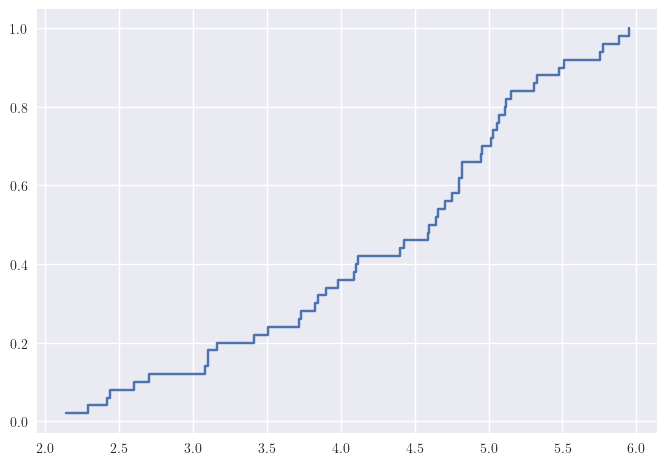

In [252]:
# сначала построим график чисто по выборке
n = len(X)
X_sorted = np.sort(X)
F = np.arange(1, n + 1) / n

plt.step(X_sorted, F, where="post")
plt.show()

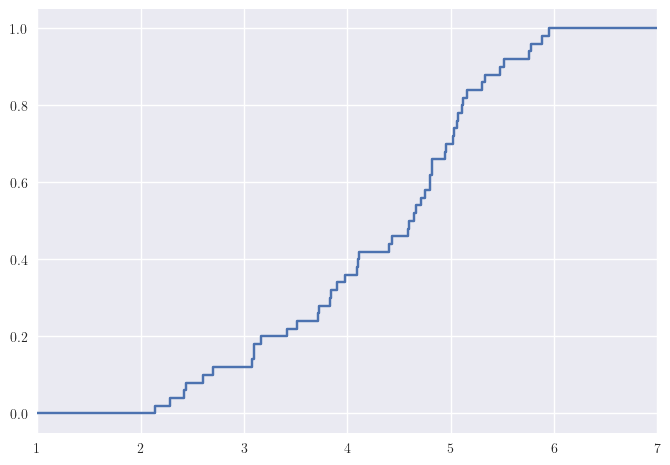

In [254]:
# теперь построим с "хвостиками"
X_sorted = np.concatenate(([-10000], X_sorted, [10000]))
F = np.concatenate(([0], F, [1]))

plt.step(X_sorted, F, where="post")
plt.xlim(1, 7)
plt.show()

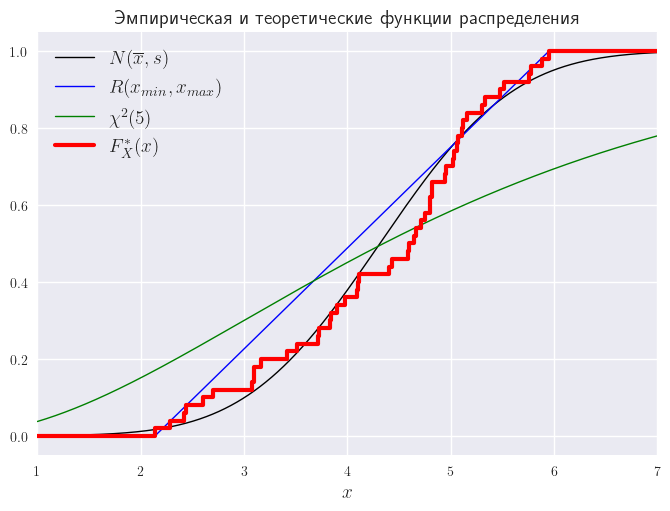

In [255]:
x = np.linspace(0, 10, 10000)
norm = stats.norm.cdf(x, loc=X.mean(), scale=X.std(ddof=1))
uniform = stats.uniform.cdf(x, loc=X.min(), scale=X.max() - X.min())
chi2 = stats.chi2.cdf(x, df=5)

plt.plot(x, norm, color="black", linewidth=1, label=r"$N(\overline x, s)$")
plt.plot(x, uniform, color="b", linewidth=1, label=r"$R(x_{min}, x_{max})$")
plt.plot(x, chi2, color="g", linewidth=1, label=r"$\chi^2(5)$")
plt.step(X_sorted, F, where="post", color="r", linewidth=3, label=r"$F^*_X(x)$")

plt.title("Эмпирическая и теоретические функции распределения", fontsize=14)
plt.xlim(1, 7)
plt.legend(fontsize=14)
plt.xlabel("$x$", fontsize=14)

plt.show()

## 5. Двухвыборочные характеристики

In [185]:
Y = np.random.uniform(a2, b2, n2)

mprint(f"$\\mathbf{{Y}}$: {Y[:10].round(2)}")

$\mathbf{Y}$: [2.61 5.65 4.55 4.36 5.13 4.82 5.69 5.83 3.27 3.17]

### Характеристики наблюдаемой величины $\mathbf Y$

| Распределение | Параметры          | Математическое ожидание          | Дисперсия                                               |
| ------------- | ------------------ | -------------------------------- | ------------------------------------------------------- |
| $R(2, 6)$     | $a_2 = 2, b_2 = 6$ | $m_2 = \dfrac{a_2 + b_2}{2} = 4$ | $\sigma_2^2 = \dfrac{(b_2 - a_2)^2}{12} = \dfrac{4}{3}$ |

### Графики

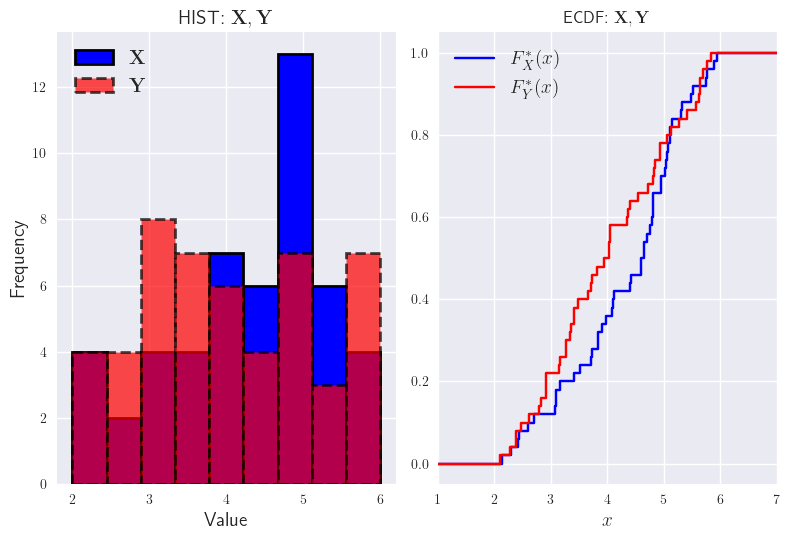

In [275]:
frequencesX, bin_edges = np.histogram(X, bins=9, range=(2, 6))
frequencesY, _ = np.histogram(Y, bin_edges)
plt.subplot(1, 2, 1)
plt.hist(
    X, bins=bin_edges, color="b", edgecolor="black", linewidth=2, label=r"$\mathbf X$"
)
plt.hist(
    Y,
    bins=bin_edges,
    color="r",
    edgecolor="black",
    alpha=0.7,
    linestyle="--",
    linewidth=2,
    label=r"$\mathbf Y$",
)
plt.legend(fontsize=14)
plt.xlabel("Value", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title(r"HIST: $\mathbf X, \mathbf Y$", fontsize=14)


n = len(X)
m = len(Y)

X_sorted = np.concatenate(([-10000], np.sort(X), [10000]))
F_x = np.concatenate(([0], np.arange(1, n + 1) / n, [1]))

Y_sorted = np.concatenate(([-10000], np.sort(Y), [10000]))
F_y = np.concatenate(([0], np.arange(1, m + 1) / m, [1]))

plt.subplot(1, 2, 2)
plt.step(X_sorted, F_x, where="post", color="b", label=r"$F_X^*(x)$")
plt.step(Y_sorted, F_y, where="post", color="r", label=r"$F_Y^*(x)$")
plt.legend(fontsize=14)
plt.xlabel(r"$x$", fontsize=14)
plt.title(r"ECDF:  $\mathbf X, \mathbf Y$")
plt.xlim(1, 7)


plt.tight_layout()
plt.show()

### Двухвыборочный критерий $\chi^2$

#### Теоретическая справка

У нас есть две выборки объёмов $n$ и $m$: 
$$x_1, x_2, \dots, x_n \text{- случайной величины } \mathbf X \sim F_X(x)$$
$$y_1, y_2, \dots, y_m \text{- случайной величины } \mathbf Y \sim F_Y(x)$$

Мы хотим понять, получены ли они из одной генеральной совокупности:
$$ H_0:\ F_X(x) = F_Y(x) $$
$$ H_1:\ F_X(x) \neq F_Y(x)  $$

Идея та же, что и у одновыборочного критерия $\chi^2$: cтроятся две гистограммы и сравниваются их высоты. Рекомендуется брать $\Delta_i$ так, чтобы $n_i + m_i \gtrsim 5$.

| $\Delta_i$ | $\Delta_1$ | $\cdots$ | $\Delta_k$ |
| ---------- | ---------- | -------- | ---------- |
| $n_i$      | $n_1$      | $\cdots$ | $n_k$      |
| $m_i$      | $m_1$      | $\cdots$ | $m_k$      |

Статистика критерия: 
$$Z = nm \cdot \sum\limits_{i=1}^k \dfrac{1}{n_i + m_i}\left( \dfrac{n_i}{n} - \dfrac{m_i}{m} \right)^2$$
$$Z \mid_{H_0} \sim \chi^2(k-1)$$

#### Код

In [288]:
def chi2_2samp(X, Y, bins):
    n = len(X)
    m = len(Y)
    frequencesX, bin_edges = np.histogram(
        X, bins=bins, range=(min(min(X), min(Y)), max(max(X), max(Y)))
    )
    frequencesY, bin_edges = np.histogram(Y, bins=bin_edges)
    z = (
        n
        * m
        * sum((frequencesX / n - frequencesY / m) ** 2 / (frequencesX + frequencesY))
    )
    p_value = stats.chi2.sf(z, df=8)
    return z, p_value

In [290]:
z, p_value = chi2_2samp(X, Y, bins=9)

mprint(
    r"### 2-sample $\chi^2$ test",
    f"$H_0: F_X(x) = F_Y(x)$",
    f"$z_{{выб}} =$ {z:.2f}",
    f"$p =$ {p_value:.2f}",
    verdict(alpha, p_value),
)

### 2-sample $\chi^2$ test

$H_0: F_X(x) = F_Y(x)$

$z_{выб} =$ 7.12

$p =$ 0.52

$H_0$ принимается

| Критерий | Статистическая гипотеза $H_0$ | Выборочное значение статистики критерия | $p$-value | Статистическое решение при $\alpha = 0.05$ | Ошибка статистического решения |
| -------- | ----------------------------- | --------------------------------------- | --------- | ------------------------------------------ | ------------------------------ |
| $\chi^2$ | $F_X(x) = F_Y(x)$             | 7.12                                    | 0.52 | $H_0$ принимается                          | Нет                            |


### Двухвыборочный критерий Колмогорова

In [291]:
z, p_value = stats.ks_2samp(X, Y)

mprint(
    r"### 2-sample ks-test",
    f"$H_0: F_X(x) = F_Y(x)$",
    f"$z_{{выб}} =$ {z:.2f}",
    f"$p =$ {p_value:.2f}",
    verdict(alpha, p_value),
)

### 2-sample ks-test

$H_0: F_X(x) = F_Y(x)$

$z_{выб} =$ 0.22

$p =$ 0.18

$H_0$ принимается

| Критерий | Статистическая гипотеза $H_0$ | Выборочное значение статистики критерия | $p$-value | Статистическое решение при $\alpha = 0.05$ | Ошибка статистического решения |
| -------- | ----------------------------- | --------------------------------------- | --------- | ------------------------------------------ | ------------------------------ |
| KS-test  | $F_X(x) = F_Y(x)$             | 0.22                                    | 0.18      | $H_0$ принимается                          | Нет                            |


### Критерий знаков

In [ ]:
z, p_value = sign_test(X - Y)
mprint(
    r"### Sign test",
    f"$H_0: F_X(x) = F_Y(x)$",
    f"$z_{{выб}} =$ {z:.2f}",
    f"$p =$ {p_value:.2f}",
    verdict(alpha, p_value),
)

### Sign test

$H_0: F_X(x) = F_Y(x)$

$z_{выб} =$ 5.00

$p =$ 0.20

$H_0$ принимается

| Критерий  | Статистическая гипотеза $H_0$ | Выборочное значение статистики критерия | $p$-value | Статистическое решение при $\alpha = 0.05$ | Ошибка статистического решения |
| --------- | ----------------------------- | --------------------------------------- | --------- | ------------------------------------------ | ------------------------------ |
| Sign test | $F_X(x) = F_Y(x)$             | 5                                       | 0.20      | $H_0$ принимается                          | Нет                            |


### Критерий Манна-Уитни

In [307]:
# манна уитни
z, p_value = stats.mannwhitneyu(X, Y)

mprint(
    r"### U-test",
    f"$H_0: F_X(x) = F_Y(x)$",
    f"$z_{{выб}} =$ {z:.2f}",
    f"$p =$ {p_value:.2f}",
    verdict(alpha, p_value),
)

### U-test

$H_0: F_X(x) = F_Y(x)$

$z_{выб} =$ 1459.00

$p =$ 0.15

$H_0$ принимается

| Критерий | Статистическая гипотеза $H_0$ | Выборочное значение статистики критерия | $p$-value | Статистическое решение при $\alpha = 0.05$ | Ошибка статистического решения |
| -------- | ----------------------------- | --------------------------------------- | --------- | ------------------------------------------ | ------------------------------ |
| U-test   | $F_X(x) = F_Y(x)$             | 1459                                    | 0.15      | $H_0$ принимается                          | Нет                            |
